# 0. Converter COCO para YOLO

In [102]:
import os
import xmltodict
from math import ceil, floor
import random
import shutil

In [72]:
PROCESSED_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'processedimages')

In [73]:
def convert_coco_to_yolo(coco_xml_dir, yolo_txt_dir, class_mapping):
    for filename in os.listdir(coco_xml_dir):
        if filename.endswith(".xml"):
            with open(os.path.join(coco_xml_dir, filename), 'r') as file:
                data = xmltodict.parse(file.read())

            img_width = int(data['annotation']['size']['width'])
            img_height = int(data['annotation']['size']['height'])

            yolo_txt_path = os.path.join(yolo_txt_dir, filename.replace(".xml", ".txt"))

            with open(yolo_txt_path, 'w') as file:
                for obj in data['annotation']['object']:
                    class_name = obj['name']
                    class_id = class_mapping.get(class_name)
                    
                    if class_id is not None:
                        x_min = int(obj['bndbox']['xmin'])
                        y_min = int(obj['bndbox']['ymin'])
                        x_max = int(obj['bndbox']['xmax'])
                        y_max = int(obj['bndbox']['ymax'])

                        x_center = (x_min + x_max) / 2 / img_width
                        y_center = (y_min + y_max) / 2 / img_height
                        width = (x_max - x_min) / img_width
                        height = (y_max - y_min) / img_height

                        file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

In [74]:
class_mapping = {
    'propria': 0,
    'impropria': 1
}

convert_coco_to_yolo(PROCESSED_PATH, PROCESSED_PATH, class_mapping)

In [75]:
!del {PROCESSED_PATH}\*.xml

# 1. Mover as imagens para os grupos de treino e teste

## Criar caminhos para as pastas

In [76]:
TRAIN_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'train')
TEST_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'test')

## Selecionar arquivos aleatórios para teste e treino

In [77]:
files = os.listdir(PROCESSED_PATH)

In [79]:
def escolher_numeros_aleatorios(seed, minimo, maximo, qtd_numeros):
    if qtd_numeros == len(os.listdir(PROCESSED_PATH)):
        return range(qtd_numeros)
        
    random.seed(seed)
    if qtd_numeros > (maximo - minimo + 1):
        return "Impossível selecionar essa quantidade de números únicos dentro do intervalo."
    
    numeros_escolhidos = []
    
    while len(numeros_escolhidos) < qtd_numeros:
        novo_numero = random.randint(minimo, maximo)
        if novo_numero not in numeros_escolhidos:
            numeros_escolhidos.append(novo_numero)
    
    return numeros_escolhidos

In [104]:
train_ratio = 0.7
test_ratio = floor(((1 - train_ratio) * 100)) / 100
print(test_ratio)

0.3


In [86]:
max = len(files) // 2 - 1
count = ceil((len(files) // 2) * train_ratio)
train_idx = escolher_numeros_aleatorios(420, 0, max, count)
test_idx = [x for x in range(len(files) // 2) if x not in train_idx]

## Separar grupo de imagens

In [78]:
def copy_img_txt(destination_path, array_idx):
    for idx in array_idx:
        selected_img = [file for file in files if file.endswith(f'_{idx + 1}.jpg')][0]
        selected_txt = [file for file in files if file.endswith(f'_{idx + 1}.txt')][0]

        source_file_path = os.path.join(PROCESSED_PATH, selected_img)
        destination_file_path = os.path.join(destination_path, selected_img)
        shutil.copyfile(source_file_path, destination_file_path)

        source_file_path = os.path.join(PROCESSED_PATH, selected_txt)
        destination_file_path = os.path.join(destination_path, selected_txt)
        shutil.copyfile(source_file_path, destination_file_path)

In [81]:
!del /Q {TRAIN_PATH}\*
!del /Q {TEST_PATH}\*

In [82]:
copy_img_txt(TRAIN_PATH, train_idx)
copy_img_txt(TEST_PATH, test_idx)

# 2. Treinamento

In [87]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

## Carregamento dos dados YOLO

In [88]:
diretorio_base = os.path.join('Tensorflow', 'workspace', 'images')

labels = []
features = []

In [89]:
def load_yolo_annotations(file_path):
    with open(file_path, 'r') as file:
        annotation_data = file.readlines()

    return annotation_data

In [90]:
def process_yolo_annotations(annotation_data):

    for annotation_line in annotation_data:
        items = annotation_line.strip().split()
            
        class_label = int(items[0].split('.')[0])
        coordinates = [float(item) for item in items[1:]]

        labels.append(class_label)
        features.append(coordinates)
    return labels, features

## Processar labels YOLO

In [91]:
for subpasta in ['train', 'test']:
    caminho_subpasta = os.path.join(diretorio_base, subpasta)

    for arquivo in os.listdir(caminho_subpasta):
        if arquivo.endswith('.txt'):
            caminho_txt = os.path.join(caminho_subpasta, arquivo)

            annotation_data = load_yolo_annotations(caminho_txt)
            txtLido = process_yolo_annotations(annotation_data)

## Treinamento dos dados com modelo Random Forest

In [105]:
features = np.array(features)

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=test_ratio, train_size=train_ratio, random_state=40)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)
y_test_pred = predictions

conf_matrix = confusion_matrix(Y_test, predictions)
accuracy = accuracy_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions, average='weighted')
precision = precision_score(Y_test, y_test_pred, average='weighted')
Revocacao = recall_score(Y_test, y_test_pred, average='weighted')

print (predictions)
print(f'Acuracia do modelo: {accuracy}')
print(f'F1: {f1}')
print(f'Precisao: {precision}')
print(f'Revocacao: {Revocacao}')
print(f'Matriz de Confusão: {conf_matrix}')

[0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0
 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0
 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0
 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0
 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1
 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1
 0 1 1 0 0 1 0 1 1 1 0 0 0 1]
Acuracia do modelo: 0.9194139194139194
F1: 0.9194420963651733
Precisao: 0.9195690880455959
Revocacao: 0.9194139194139194
Matriz de Confusão: [[132  12]
 [ 10 119]]


## Exibição gráfica dos resultados

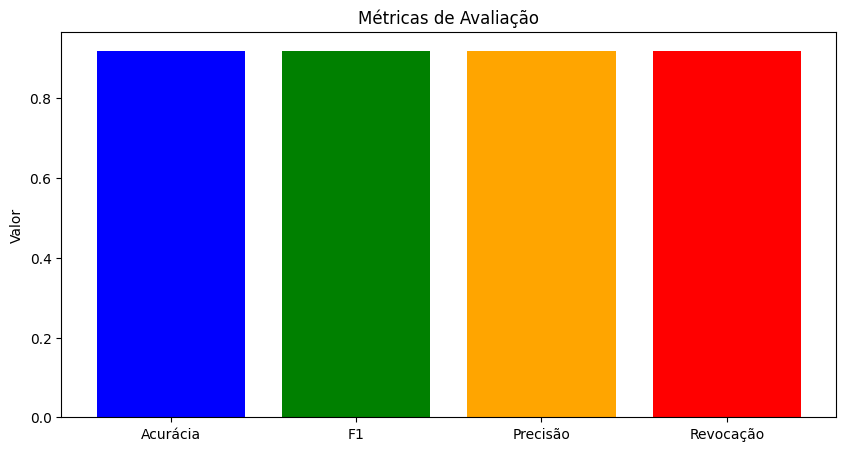

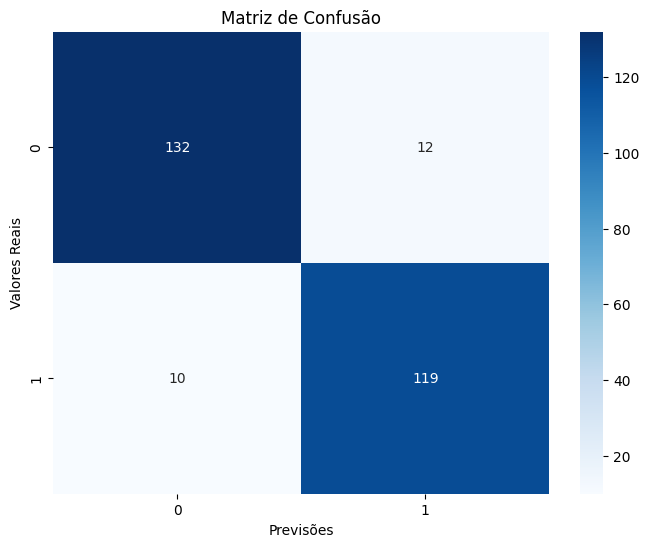

In [106]:
metrics_names = ['Acurácia', 'F1', 'Precisão', 'Revocação']
metrics_values = [accuracy, f1, precision, Revocacao]

plt.figure(figsize=(10, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
plt.title('Métricas de Avaliação')
plt.ylabel('Valor')
plt.show()

# Gráfico de matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matriz de Confusão')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.show()